## Main experiments and results mentioned in March suggestions.

### NOTE, WINDOWS USER:
#### If you are running this with windows, the random seeds may not be the same. Use the commented-out windows seeds to confirm the results (not exactly the same NMI values, but in the ballpark).

# --------------------------------------------------------------------------------

**This notebook holds the experiments and results that are referred to in the report. Most of the code/functions are hidden behind the 'Functions.py', and simply called from this notebook.**

In [1]:
from Functions import *

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/paavo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/paavo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/paavo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# -------------------------------------------------------------------------------

**As per initial experiments, appending TITLE and ABSTRACT provided the best performance - therefore, only appended data is used in these main experiments.**

In [2]:
data_all = pd.read_csv('./data/allData.csv', sep='#')
data = data_all['APPTEXT']
data_np=data.to_numpy()
classes = data_all['CLASS']

le = LabelEncoder()
le.fit(classes)
true_labels = le.transform(classes)

# -------------------------- Basic K-Means (models 1.i and 1.ii) --------

Basic K-Means without added stopwords (i.e., using nltk.corpus stopwords only) results in $NMI=0.8373$, and with 4 added stopwords results in $NMI=0.8456$. In both cases, all numbers and number-character combos (e.g., 1d, 2d, 3g) are removed, the minimum length of tokens is set to greater than 2, and snowball stemmer is used (instead of pos-tagging and lemmatization). Only mono-grams are used in both cases.

Tf-idf calculations are done using sklearns TfidfVectorizer, with sublinear scaling - $\mathbf{tf}_{sublin} = 1 + \log{(\mathbf{tf})}$, and without smoothing (as the vocabulary is determined from the data, there is no risk for zero division) - i.e., $\mathbf{idf}$ is simply the inverse document frequency of a given term.

The definition of Preprocessor is in the separate 'Functions.py' file.

**NOTE:** In the following section, there is a Pipelined solution for fast experiments and/or confirmation of the results.

**Run either one of the following $\mathbf{sw}$ definitions (see WINDOWS seed).**

In [3]:
sw1=set()
rs1=52508 #WINDOWS: 18272

In [6]:
sw1=set(['use','paper','based','propos'])
rs1=52508 #WINDOWS: 17149

In [7]:
proc_1 = Preprocessor(stem=True, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=sw1, \
                                        verbose=False)

tokens_1=proc_1.fit_transform(data_np)
tfidf_1=TfidfVectorizer(smooth_idf=False,sublinear_tf=True,ngram_range=(1,1))

features_1=tfidf_1.fit_transform(tokens_1)
features_1.shape

(1332, 7992)

In [8]:
init='k-means++'
kmeans_model_1 = KMeans(n_clusters=5,init=init, random_state=rs1).fit(features_1)
print('NMI: {}'.format(normalized_mutual_info_score(true_labels,\
                                                    kmeans_model_1.labels_,\
                                                   average_method='geometric')))

NMI: 0.8456092400330414


**Multiple runs of kmeans, for experimentation:**

In [13]:
#run_kmeans_experiments(features_1,true_labels, repeats=10, verbose=True)

# ----------------- K-Means Pipelined (model 1.i, 1.ii) -----------------

**Run either one of the following $\mathbf{sw}$ definitions (see WINDOWS seed).**

In [ ]:
sw1=set()
rs1=52508 #WINDOWS: 18272

In [23]:
sw1=set(['use','paper','based','propos'])
rs1=52508 #WINDOWS: 17149

In [24]:
model_1 = Pipeline([
            ('preprocessor', Preprocessor(nonumbers=True, stem=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=sw1)),
            ('vectorizer', TfidfVectorizer(
                preprocessor=None, lowercase=False, ngram_range=(1,1),\
                smooth_idf=False,sublinear_tf=True)),
            ('clusterer', KMeans(n_clusters=5, init="k-means++", random_state=rs1))
        ])

result_1=model_1.fit(data.to_numpy())
y_hat_1=result_1.predict(data.to_numpy())
normalized_mutual_info_score(true_labels,y_hat_1, average_method='geometric')

0.8456092400330414

# -------------------- Improved K-Means (1.iii) ---------------------------

**NOTE: There is no seed for WINDOWS seed; this result is not in the report.**

The K-Means can be slightly improved by pruning roughly $3/4$ of the features, as well as removing one token that all clusters share, 'use', by adding it to stopwords. 

**NOTE:** Through all the experiments, ~1300 mono-gram features were optimal; adding more or using less resulted in poorer performance. Even with dim-reduction or spectral embeddings, the same feature count performed the best. However, with mono- and bi-grams, spectral embedding can provide slightly higher NMI (also more stable) using more features (as will be demonstrated shortly).

In [11]:
sw2=set(['use'])

In [12]:
rs2=25503

In [13]:
proc_2 = Preprocessor(stem=True, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=sw2, \
                                        verbose=False)

tokens_2=proc_2.fit_transform(data_np)
tfidf_2=TfidfVectorizer(max_df=1.0, min_df=0.01,\
                        ngram_range=(1,1),smooth_idf=False,sublinear_tf=True)

features_2=tfidf_2.fit_transform(tokens_2)
features_2.shape

(1332, 1312)

In [14]:
kmeans_model_2 = KMeans(n_clusters=5,init='k-means++',random_state=rs2).fit(features_2)
normalized_mutual_info_score(true_labels,kmeans_model_2.labels_, average_method='geometric')

0.8524458410075084

In [142]:
#run_kmeans_experiments(features_2,true_labels, repeats=10, verbose=True)

### T-SNE visualization of the K-Means clustering (not in the report)

In [37]:
X_emb = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(features_2)

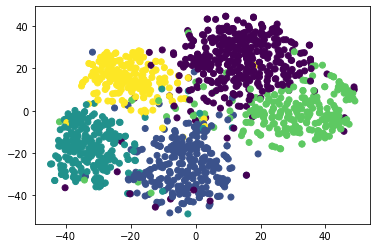

In [38]:
plt.scatter(X_emb[:,0],X_emb[:,1],c=kmeans_model_2.labels_)

# --------------- Improved K-Means Pipelined (model 1.iii) ----------

**Same as previous, not in the report.**

In [25]:
sw2=set(['use'])

In [26]:
rs2 = 25503

model_2 = Pipeline([
            ('preprocessor', Preprocessor(nonumbers=True, stem=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=sw2)),
            ('vectorizer', TfidfVectorizer(max_df=1.0, min_df=0.01,\
                preprocessor=None, lowercase=False, ngram_range=(1,1),\
                smooth_idf=False,sublinear_tf=True)),
            ('clusterer', KMeans(n_clusters=5, init="k-means++", random_state=rs2))
        ])

result_2=model_2.fit(data.to_numpy())
y_hat_2=result_2.predict(data.to_numpy())
normalized_mutual_info_score(true_labels,y_hat_2, average_method='geometric')

0.8524458410075084

# ---------------------------- Spectral Clustering -------------------------

**This clustering will be used for the reports final topic/cluster analysis.**

In [3]:
proc_3 = Preprocessor(stem=True, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=set(), \
                                        verbose=False)

tokens_3=proc_3.fit_transform(data_np)
tfidf_3=TfidfVectorizer(smooth_idf=False,sublinear_tf=True,max_features=1700,ngram_range=(1,2))

features_3=tfidf_3.fit_transform(tokens_3)
features_3.shape

(1332, 1700)

**(change the seed for WINDOWS)**

In [4]:
rs3=96703 #WINDOWS: 89414

In [5]:
sim = pairwise_kernels(features_3,gamma=1/2000, metric='laplacian')
data_emb = SpectralEmbedding(n_components=28, eigen_solver='arpack',\
                             affinity='precomputed').fit_transform(sim)
data_emb=normalize(data_emb)

In [6]:
init='k-means++'
spectral_model = KMeans(n_clusters=5,init=init, random_state=rs3).fit(data_emb)
normalized_mutual_info_score(true_labels,spectral_model.labels_, average_method='geometric')

0.8604308555095805

**You can run some experiments, to see how stable the results are (compared to basic K-Means).**

In [39]:
#run_kmeans_experiments(data_emb, true_labels, repeats=10, verbose=True)

**Or, alternatively using self-defined functions (change the seed for WINDOWS):**

In [7]:
rs4=39041 #WINDOWS: 52600

In [8]:
L = laplacian(sim, normalize='sym')
data_emb2=spect_embedding(L, n_components=28, normalized=True)

In [9]:
init='k-means++'
spectral_model_2 = KMeans(n_clusters=5,init=init, random_state=rs4).fit(data_emb2)
normalized_mutual_info_score(true_labels,spectral_model_2.labels_, average_method='geometric')

0.8603505678937396

**For experiments:**

In [41]:
#run_kmeans_experiments(data_emb2, true_labels, repeats=10, verbose=True)

**NOTE: At the end of this notebook, there is a chapter named "Spectral clustering performance", which demonstrates the performance of spectral embedding with different normalization schemes, using the embedding/feature space (28 components). It is rather trivial to get results in the order of NMI=0.84-0.86, and with high consistency. There are no seeds for testing on windows (these results are not in the report)**

# ------------------- Cluster/Topic analysis -------------

### These are using the previous spectral clustering results (labels are 'spectral_model.labels_'). Just adding some non-informative tokens to stopwords.

In [7]:
proc_final = Preprocessor(stem=True, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=set(['use','paper','based','propos']), \
                                        verbose=False)

tokens_final=proc_final.fit_transform(data_np)
tfidf_final=TfidfVectorizer(smooth_idf=False,sublinear_tf=True,max_features=1700,ngram_range=(1,2))

features_final=tfidf_final.fit_transform(tokens_3)

**Let's build a countVectorizer from the same tokens that were used to train the spectral model:**

In [8]:
cvec=CountVectorizer(max_features=1700,ngram_range=(1,2))
counts = cvec.fit_transform(tokens_final)
counts = counts.todense()

## NOTE:
**Ignore the following warnings; they can not be avoided if we like to retain compatibility between different scikit-learn versions. The warnings come from using .get_feature_names() instead of .get_feature_names_out() in the table_top_words() -function.**

In [12]:
import warnings
warnings.filterwarnings("ignore")

**Now, we can list the most (top-k) significant features all together (mono-and possibly bi-grams). NOTE: The cluster labels are not the same as the underlying true classes, and need to be correctly mapped (for the report).**

In [13]:
tops=top_cluster_features(counts, spectral_model.labels_,k=k)
table1=table_top_words(cvec,tops)
table1.columns = ['Cluster 0', 'Cluster 1', 'Cluster 2',\
           'Cluster 3', 'Cluster 4']
table1

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,databas,imag,robot,compil,secur
1,data,method,control,program,scheme
2,relat,detect,system,comput,key
3,system,model,perform,code,encrypt
4,queri,comput,model,languag,data


**As there is only one bi-gram among the top-10 features (and none in top-5), we should also table the most significant bi-grams (whether or not they are among the most significant features overall):**

In [13]:
cvec_bigram=CountVectorizer(max_features=100,ngram_range=(2,2))
counts_bigram=cvec_bigram.fit_transform(tokens_final)
counts_bigram = counts_bigram.todense()

In [16]:
tops_bigram=top_cluster_features(counts_bigram, spectral_model.labels_,k=5)
table2=table_top_words(cvec_bigram,tops_bigram)
table2.columns = ['(Bi)Cluster 0', '(Bi)Cluster 1', '(Bi)Cluster 2',\
           '(Bi)Cluster 3', '(Bi)Cluster 4']
table2

,(Bi)Cluster 0,(Bi)Cluster 1,(Bi)Cluster 2,(Bi)Cluster 3,(Bi)Cluster 4
0,relat databas,comput vision,soft robot,program languag,quantum comput
1,inform system,deep learn,robot system,high level,post quantum
2,big data,neural network,human robot,run time,public key
3,databas manag,convolut neural,result show,regist alloc,ellipt curv
4,manag system,real time,real time,quantum comput,internet thing


**Finally, we can use LSA, in a somewhat unconventional way:  We extract a single topic, as defined by 5-10 most significant mono-or bi-grams, to describe each cluster. Unlike for clustering, for the topics we choose to use lemmatized tokens (stem=False, otherwise as before)**

In [14]:
proc_lemm = Preprocessor(stem=False, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=set(['use','paper','based','propos']), \
                                        verbose=False)

tokens_lemm=proc_lemm.fit_transform(data_np)
tfidf_lemm=TfidfVectorizer(smooth_idf=False,sublinear_tf=True,max_features=1700,ngram_range=(1,2))

features_lemm=tfidf_lemm.fit_transform(tokens_lemm)
features_lemm=features_lemm.todense()

**And then printing a single topic for each cluster:**

In [15]:
all_tokens=[]
for c in range(5):
    cluster = features_lemm[np.where(spectral_model.labels_==c),:][0]
    cluster = np.asarray(cluster)

    topics = 1
    lsa_model = TruncatedSVD(n_components=topics, algorithm='randomized', n_iter=10, random_state=42)
    lsa_top=lsa_model.fit_transform(cluster)

    # most important words for each topic
    wpt = words_per_topic = 10
    vocab = tfidf_lemm.get_feature_names()

    for i, comp in enumerate(lsa_model.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1],\
                              reverse=True)[:wpt]
        print("Cluster "+str(c)+": ")
        for t in sorted_words:
            print('({})'.format(t[0]), end='')
            all_tokens.append(t[0])
        
        print("\n")

Cluster 0: 
(database)(relational)(relational database)(data)(query)(system)(sql)(information)(schema)(approach)

Cluster 1: 
(image)(vision)(detection)(method)(computer vision)(deep)(computer)(network)(model)(learning)

Cluster 2: 
(robot)(control)(robotic)(system)(soft)(robotics)(task)(environment)(controller)(approach)

Cluster 3: 
(compiler)(program)(code)(language)(memory)(graph)(processor)(optimization)(time)(transformation)

Cluster 4: 
(security)(scheme)(key)(cryptography)(encryption)(secure)(attack)(quantum)(protocol)(propose)



**And the same in a nice pandas dataframe:**

In [16]:
table_LSA=pd.DataFrame(np.asarray(all_tokens).reshape(-1,5,order='F'),columns=['(LSA) Cluster 0',\
                                                          '(LSA) Cluster 1',\
                                                          '(LSA) Cluster 2',\
                                                          '(LSA) Cluster 3',\
                                                          '(LSA) Cluster 4'])
table_LSA

,(LSA) Cluster 0,(LSA) Cluster 1,(LSA) Cluster 2,(LSA) Cluster 3,(LSA) Cluster 4
0,database,image,robot,compiler,security
1,relational,vision,control,program,scheme
2,relational database,detection,robotic,code,key
3,data,method,system,language,cryptography
4,query,computer vision,soft,memory,encryption
5,system,deep,robotics,graph,secure
6,sql,computer,task,processor,attack
7,information,network,environment,optimization,quantum
8,schema,model,controller,time,protocol
9,approach,learning,approach,transformation,propose


# ------------- (Extra) Spectral clustering performance ---------------------

Below are some further experiments using different normalizations for the laplacian. Clearly, symmetric normalization results in best results, and using added (row) normalization for the embedded features results in more stable clustering.

**No additional stopwords, since these are just experiments for high NMI.**

**Still using the same Preprocessing (mono- and bi-grams, 1700 features):**

In [6]:
proc = Preprocessor(stem=True, nonumbers=True, min_length=2, \
                                        numencode='drop',\
                                        stopwords=set(), \
                                        verbose=False)

res1=proc.fit_transform(data_np)
tfidf=TfidfVectorizer(smooth_idf=False,sublinear_tf=True,max_features=1700,ngram_range=(1,2))

res2=tfidf.fit_transform(res1)
res3=res2.todense()

res3.shape

(1332, 1700)

**All of the following are using same laplacian similarity kernel, with slightly longer length scale than the default values (default would be 1/1700).**

In [7]:
sim = pairwise_kernels(res2,gamma=1/2000, metric='laplacian')

**Sklearn's spectral embedding (un-normalized):**

In [8]:
data_emb = SpectralEmbedding(n_components=28, eigen_solver='arpack',\
                             affinity='precomputed').fit_transform(sim)

**Normalizing the embedding:**

In [9]:
data_emb2=normalize(data_emb)

**Self defined spectral embedding/eigenmap, with symmetric laplacian, and normalized features:**

In [10]:
sim = pairwise_kernels(res2,gamma=1/2000, metric='laplacian')
L = laplacian(sim, normalize='sym')
data_emb3=spect_embedding(L, n_components=28, normalized=True)

**The un-normalized features produce higher variance in the clustering results (which can result in high NMI as well), that are typically lower compared to normalized features:**

In [78]:
#Un-normalized embedding
#run_kmeans_experiments(data_emb, true_labels, 100, verbose=True)

max: 0.8345986041583318
average: 0.8179332195284763
seed: 50171


(0.8345986041583318, 50171)

**Normalized features get more stable high results:**

In [74]:
#Normalised embedding
#run_kmeans_experiments(data_emb2, true_labels, 100, verbose=True)

max: 0.8604293307613384
average: 0.8446620618408137
seed: 96703


(0.8604293307613384, 96703)

In [13]:
#Also normalized embedding (self-defined, for more control, for experiments)
#run_kmeans_experiments(data_emb3, true_labels, 50, verbose=True)

max: 0.8548991246887065
average: 0.8447172909935345
seed: 63816


(0.8548991246887065, 63816)

In [71]:
init='k-means++'
spec_model = KMeans(n_clusters=5,init=init, random_state=25587).fit(data_emb)
normalized_mutual_info_score(true_labels,spec_model.labels_, average_method='geometric')

0.8224745893745538

In [76]:
init='k-means++'# 28 compon, normalize
spec_model = KMeans(n_clusters=5,init=init, random_state=96703).fit(data_emb2)
normalized_mutual_info_score(true_labels,spec_model.labels_, average_method='geometric')

0.8604308555095805

In [77]:
init='k-means++'#sym, 28 compon, normalized
spec_model = KMeans(n_clusters=5,init=init, random_state=39041).fit(data_emb3)
normalized_mutual_info_score(true_labels,spec_model.labels_, average_method='geometric')

0.8603505678937396

# ------------------------ (Parameter search) ---------------------

**Here is an example of the parameter grid search, although the entire parameter space is not represented here (for brevity). 'TITLE' and 'ABSTRACT' were tested in a similar manner.**

In [ ]:
data_all = pd.read_csv('./data/allData.csv', sep='#')
data = data_all['APPTEXT']
data_np=data.to_numpy()
classes = data_all['CLASS']

le = LabelEncoder()
le.fit(classes)
true_labels = le.transform(classes)

**For K-Means clustering: (DO NOT RUN; results already collected)**

In [ ]:
stem1 = [False, True]
sublinear1 = [False, True]
df_min1 = [0.005, 0.01, 0.015]
ngrams1 = [1,2,3]

#filename = './data/results_kmeans_appended.csv'

In [ ]:
with open(filename, 'w') as f:
    f.write("STEM,DF_MIN,SUBLINEAR,topNGRAM,avgNMI,topNMI\n")

count = 0

for stem in stem1:
    for sublinear in sublinear1:
        for df_min in df_min1:
            for ngram in ngrams1:
                proc = Preprocessor(stem=stem, nonumbers=True, min_length=2, \
                                        numencode='drop', stopwords=set(), \
                                        verbose=False)
                        
                res1=proc.fit_transform(data_np)
                tfidf=TfidfVectorizer(min_df=df_min, \
                                          sublinear_tf=sublinear, \
                                          ngram_range=(1,ngram))
                        
                res2=tfidf.fit_transform(res1)
                #res3 = np.asarray(res2.todense())
                    
                print('--- Config: {}  -------'.format(count))
                    
                NMI, AVE, SEED = run_kmeans_experiments(res2,true_labels,20, verbose=False)
                print('top-NMI: {}, avg-NMI: {}, SEED: {}'.format(NMI, AVE, SEED))
                    
                #pd.DataFrame(np.array([ngram,dfmax,dfmin,smoothidf,\
                #                       sublineartf,NMI,STD,SEED]).reshape(1,-1),columns=columns)
                    
                with open(filename, 'a') as f:
                        f.write("{},{},{},{},{},{}\n".format(stem, df_min, sublinear,\
                                                             ngram, np.round(AVE,4),\
                                                             np.round(NMI,4)))
                count+=1
    

**And similar search for spectral clustering: (DO NOT RUN; results already collected)**

In [ ]:
df_min2 = [0.005, 0.01, 0.015]
kernels=['cosine', 'rbf', 'laplacian', 'polynomial']
embeds=[20,30,40]

#filename2 = './data/results_spectral_appended.csv'

In [ ]:
with open(filename2, 'w') as f:
    f.write("STEM,DF_MIN,SUBLINEAR,KERNEL,EMB_DIM,topNGRAM,avgNMI,topNMI\n")

count = 0

for df_min in df_min2:    
    for kernel in kernels:
        for embed in embeds:
            proc = Preprocessor(stem=stem, nonumbers=True, min_length=2, \
                                            numencode='drop', stopwords=set(), \
                                            verbose=False)

            res1=proc.fit_transform(data_np)
            tfidf=TfidfVectorizer(min_df=df_min, \
                                              sublinear_tf=True, \
                                              ngram_range=(1,2))

            res2=tfidf.fit_transform(res1)
            #res3 = np.asarray(res2.todense())
            
            affin = lambda X: pairwise_kernels(X, metric=kernel)
            features_emb = SpectralEmbedding(n_components=embed, eigen_solver='arpack',\
                             affinity=affin).fit_transform(res2)
            features_emb = normalize(features_emb)
            
            print('--- Config: {}  -------'.format(count))

            NMI, AVE, SEED = run_kmeans_experiments(features_emb,true_labels,20, verbose=False)
            print('top-NMI: {}, avg-NMI: {}, SEED: {}'.format(NMI, AVE, SEED))

            #pd.DataFrame(np.array([ngram,dfmax,dfmin,smoothidf,\
            #                       sublineartf,NMI,STD,SEED]).reshape(1,-1),columns=columns)

            with open(filename2, 'a') as f:
                f.write("{},{},{},{},{},{},{},{}\n".format(True, df_min, True,\
                                                           kernel, embed, 2,\
                                                           np.round(AVE,4),\
                                                           np.round(NMI,4)))
            count+=1


# -------------------------------------------- END ----------------------------------------------------